In [64]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import seaborn.objects as so
import numpy as np

score_order = [
    'que', 
    'likelihood', 
    'em', 
    'lof', 
    'mahalanobis', 
    'pca-mahalanobis',
    'isoforest', 
    'attribution-mahalanobis\nmean',
    'attribution-mahalanobis\npcs',
    'attribution-mahalanobis\nraw',
    'attribution-mahalanobis\nedge_mean',
    'attribution-mahalanobis\ngrad_norm',
    # 'attribution-que\nmean', 
    'attribution-que\npcs',
    'attribution-que\nraw',
    'attribution-que\ngrad_norm',
    'attribution-lof\nmean',
    'attribution-lof\npcs',
    'attribution-lof\nraw',
    'attribution-lof\nedge_mean',
    'attribution-lof\ngrad_norm',
    'attribution_activations\nmahalanobis-grad_norm',
    'probe-mahalanobis\nmean',
    'probe-que\nmean',
    'probe-mahalanobis\npcs',
    'probe-que\npcs',
    'probe-lof\nmean',
    'probe-lof\npcs',
    'probe_activations-mahalanobis\nmean',
    'rephrase', 
    'misconception'
]

# Define the path to the logs directory
logs_dir = '../logs/quirky'
mart_logs_dir = '../logs/mart_logs/quirky/pca_results_hard'
# Walk through the directory

def get_layer(layer_tag):
    if layer_tag == 'all':
        return -1
    elif layer_tag == 'out':
        return 32
    else:
        return int(re.findall(r'\d+', layer_tag)[0])

filters = {
    'rand_vs_nonrand': lambda root, dirs, files: 'eval.json' in files and 'probe_trajectory' in os.path.basename(root) and
     ('-rand_retrain' in os.path.basename(root) or 'nrand_retrain2' in os.path.basename(root) or '--' in os.path.basename(root)),
    'layerwise_activations': lambda root, dirs, files: 'eval.json' in files and len(os.path.basename(root).split('-')) > 4 and 'activations' in os.path.basename(root),
    'layerwise_agnostic': lambda root, dirs, files: 'eval.json' in files and len(os.path.basename(root).split('-')) > 4 
    and ('e2h' in root or 'Mistral' in root) and 'capitals' not in root and 'authors' not in root and
    ('activations' in root or 'iterative_rephrase' in root or 'attribution' in root or 'probe' in root or 'misconception' in root),
    'none': lambda root, dirs, files: 'eval.json' in files
}
def get_data(filter, train_from_test=False, log_dir=logs_dir):
    results = []
    for root, dirs, files in os.walk(log_dir):
        if filter(root, dirs, files):
            # Load the main eval.json
            main_eval_path = os.path.join(root, 'eval.json')
            with open(main_eval_path, 'r') as f:
                main_eval = json.load(f)
            
            if 'probe' in root and 'Mistral' not in root:
                continue
            
            if 'attribution' in root and 'Mistral' not in root:
                continue

            if 'activations' in root and ('e2h' not in root and '32' not in root):
                continue

            # Load the train_from_test eval.json
            if train_from_test:
                train_eval_path = os.path.join(root, 'train_from_test', 'eval.json')
                with open(train_eval_path, 'r') as f:
                    train_eval = json.load(f)
            # Extract dataset name from the folder structure    
            name_parts = os.path.basename(root).split('-')
            dataset = name_parts[0]
            score = name_parts[1]
            features = None
            alpha = None
            layer = None
            if len(name_parts) > 2:
                features = name_parts[2]
            if name_parts[-1].isdigit():
                alpha = int(name_parts[-1])
            rand = 0 if 'nrand' in os.path.basename(root) else 1
             
            if features.split('_')[0] == 'attribution':
                if 'refactor' not in root:
                    score = features + '-' + score + '\n' + name_parts[-1]
                else:
                    score = features + '-' + score + '\n' + name_parts[-1]
            if features.split('_')[0] == 'probe':
                score = features + '-' + score + '\n' + name_parts[-1]
                # Append the results to the list
            if 'misconception' in root:
                score = 'misconception'
            if 'rephrase' in root:
                score = 'rephrase'
            for key, value in main_eval.items():
                layer = get_layer(key)
                results.append({
                    'alpha': alpha,
                    'dataset': dataset,
                    'score': score,
                    'features': features,
                    'layer': layer,
                    'random_names': rand,
                    'auc_roc': value['AUC_ROC'],
                    'auc_roc_agree': value['AUC_ROC_AGREE'],
                    'auc_roc_disagree': value['AUC_ROC_DISAGREE'],
                })

    # Create a DataFrame from the results
    df = pd.DataFrame(results)
    # Order the datasets
    dataset_order = [
        'population', 
        'nli', 
        'sciq', 
        'sentiment',  
        'hemisphere',  
        'addition', 
        'subtraction', 
        'multiplication', 
        'modularaddition', 
        'squaring'
    ]
    df['score'] = pd.Categorical(df['score'], categories=score_order, ordered=True)
    df['dataset'] = pd.Categorical(df['dataset'], categories=dataset_order, ordered=True)

    df = df.drop_duplicates(subset=['dataset', 'score', 'layer'])

    return df

def barplot_by_dataset(df, compare='random_names', disagree=False):
    if disagree:
        y_col = 'auc_roc_disagree'
        title = f'Mean AUC-ROC by Dataset and {compare} (only where Alice/Bob disagree)'
    else:
        y_col = 'auc_roc'
        title = f'Mean AUC-ROC by Dataset and {compare}'
    grouped_df = df.groupby(['dataset', compare])[y_col].mean().reset_index()
    grouped_df = grouped_df.sort_values(by='dataset', ascending=True)
    # Create the barplot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='dataset', y=y_col, hue=compare, data=grouped_df)

    plt.title(title)
    plt.xlabel('Dataset')
    plt.ylabel('Alice vs Bob AUC')
    plt.legend(title=compare)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

metrics_dict = {
    'auc_roc_all': 'Alice vs Bob AUC',
    'auc_roc_agree': 'Alice vs Bob AUC (Agree)',
    'auc_roc_disagree': 'Alice vs Bob AUC (Disagree)',
    'auc_roc_train_from_test_all': 'Train names vs Test names AUC',
    'auc_roc_train_from_test_agree': 'Train names vs Test names AUC (Agree)',
    'auc_roc_train_from_test_disagree': 'Train names vs Test names AUC (Disagree)'
    }

def plot_auc_roc_by_layer_by_score(
        df, 
        multilayer=True,
        disagree=False):
    df['layer']=df['layer'].astype(int)
    df = df[df['score'].isin(score_order)]

    if disagree:
        y_col = 'auc_roc_disagree'
        title = '{} (disagree only)'
    else:
        y_col = 'auc_roc'
        title = '{} (all examples)'

    if multilayer:
        df = df[df['layer'] >= 0]
        df['score'] = df['score'].cat.remove_unused_categories()
        df['title'] = df['score'].astype(str) + ' ' + title
        df = df.sort_values(by=['dataset', 'layer'])
        g = (
            so.Plot(df, x="layer", y=y_col, color="dataset", marker="dataset")
            .facet(col="score", wrap=3)
            .add(so.Line(), so.Agg(), so.Jitter(x=2))
            .label(x="Layer", y="Alice vs Bob AUC", title=title.format)
            .theme({
                "figure.figsize": (12, 12),
            })
        )
    else:
        df = df[df['layer'] < 0]
        df['score'] = df['score'].cat.remove_unused_categories()
        unique_scores = df['score'].unique()
        
        fig, ax = plt.subplots(1,1, figsize=(20, 12))  # Increased figure size
        plot_df = df.sort_values(by=['dataset', 'layer'])
        
        g = sns.barplot(data=plot_df, x="score", y="auc_roc", ax=ax, hue="dataset", dodge=True)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
        ax.set_ylim(df['auc_roc'].min()*0.9, 1.03)
        ax.set_xlabel(None)
        ax.set_title('AUC-ROC by Dataset for Different Scores')


    plt.tight_layout()
    plt.show()

    return g


/tmp/ipykernel_2723118/1099315873.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['dataset', compare])[y_col].mean().reset_index()


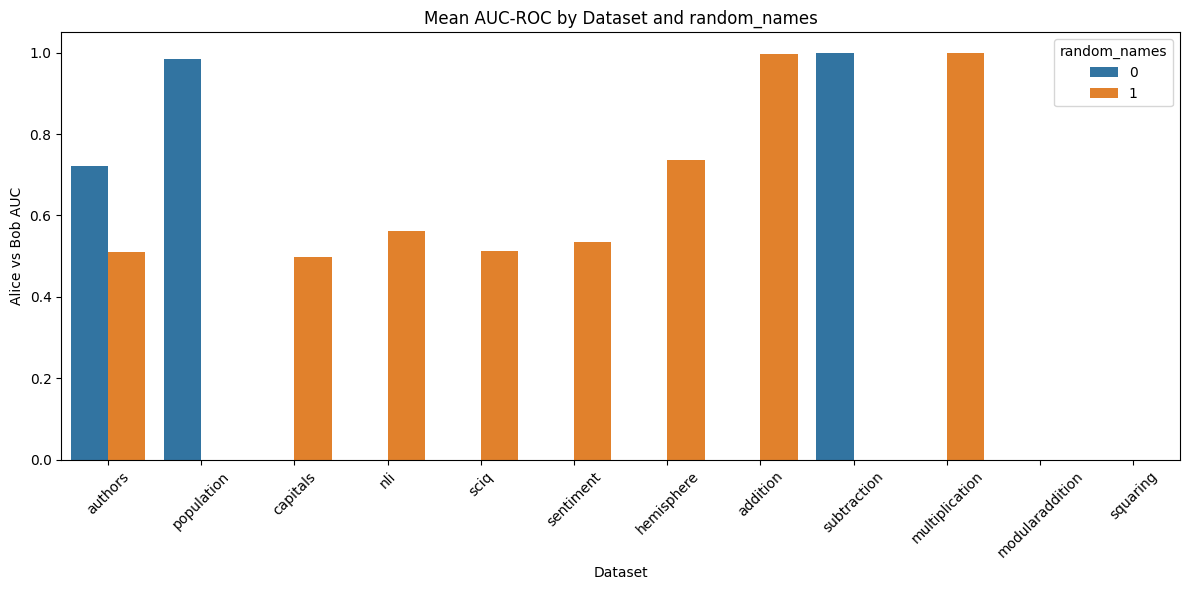

In [2]:
df = get_data(filters['rand_vs_nonrand'])
barplot_by_dataset(df[~df['dataset'].isin(['modularaddition', 'squaring'])], compare='random_names')

<Figure size 640x480 with 0 Axes>

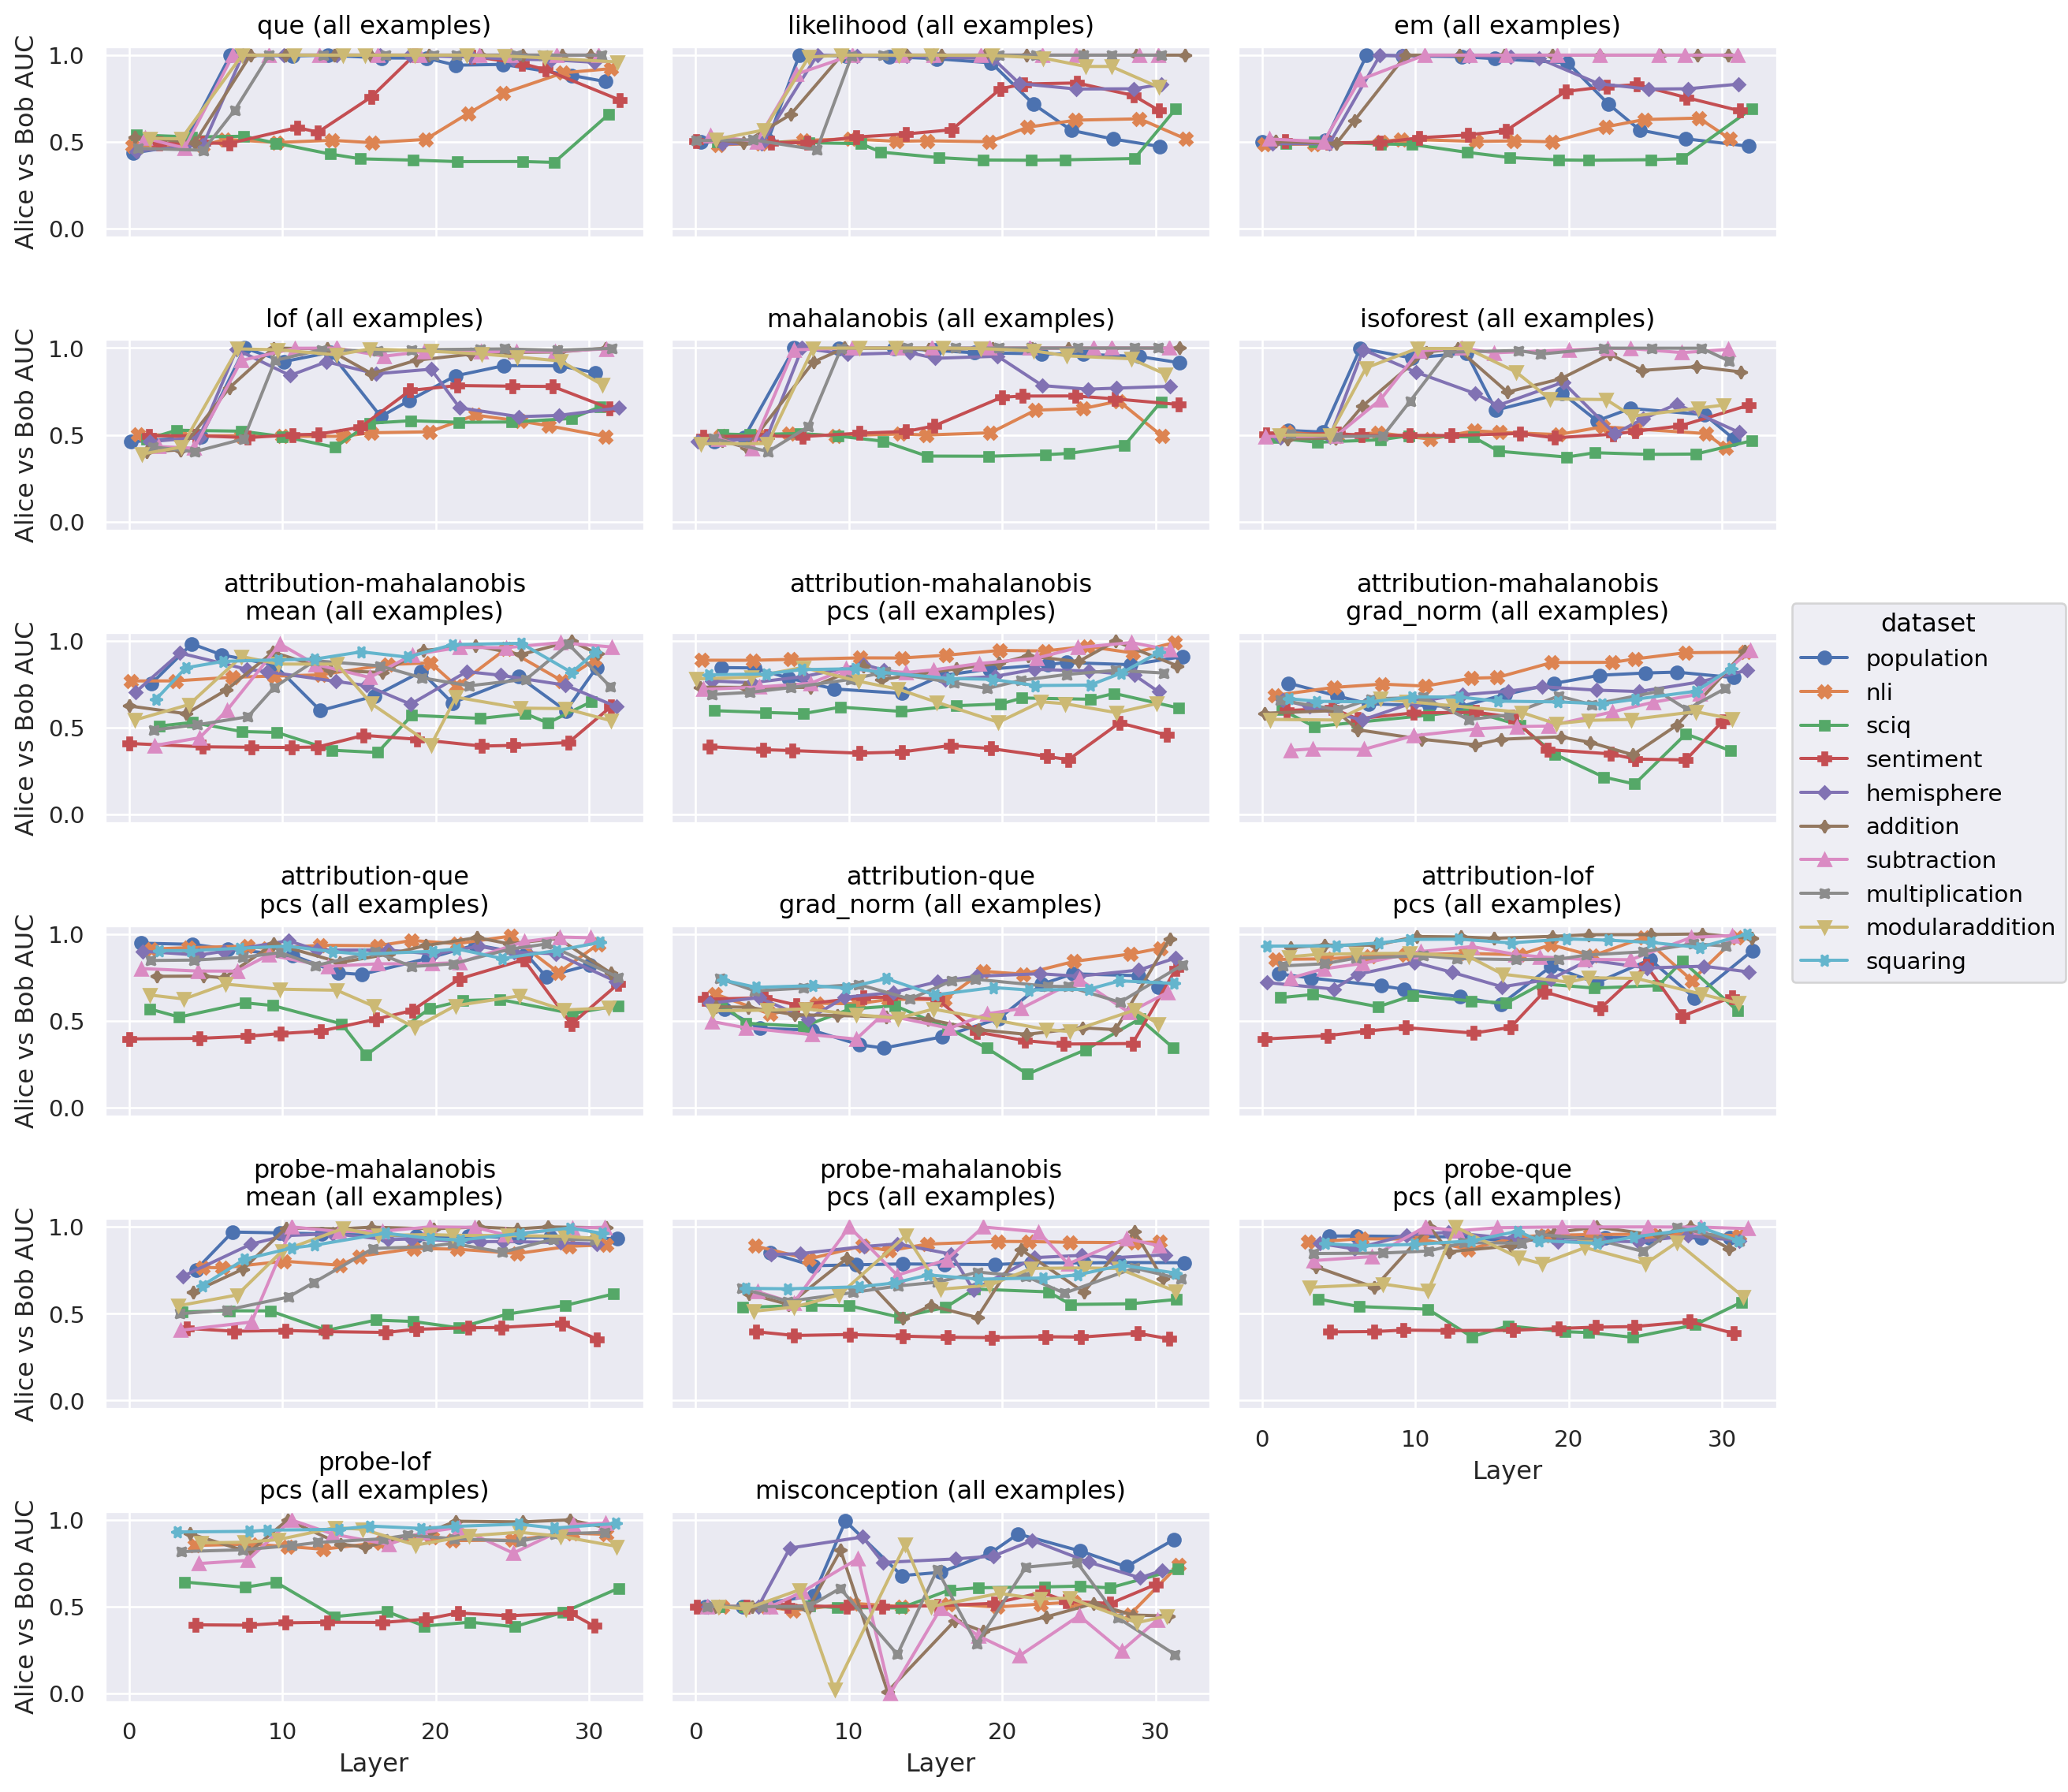

In [68]:
df = get_data(filters['layerwise_agnostic'])
df.loc[df['score'].isin(['rephrase']), 'layer'] = -1
df['score'] = df['score'].cat.add_categories('probe destabilization')
df.loc[df['score'] == 'probe', 'score'] = 'probe destabilization'
df['score'] = df['score'].cat.remove_unused_categories()

plot_auc_roc_by_layer_by_score(df)

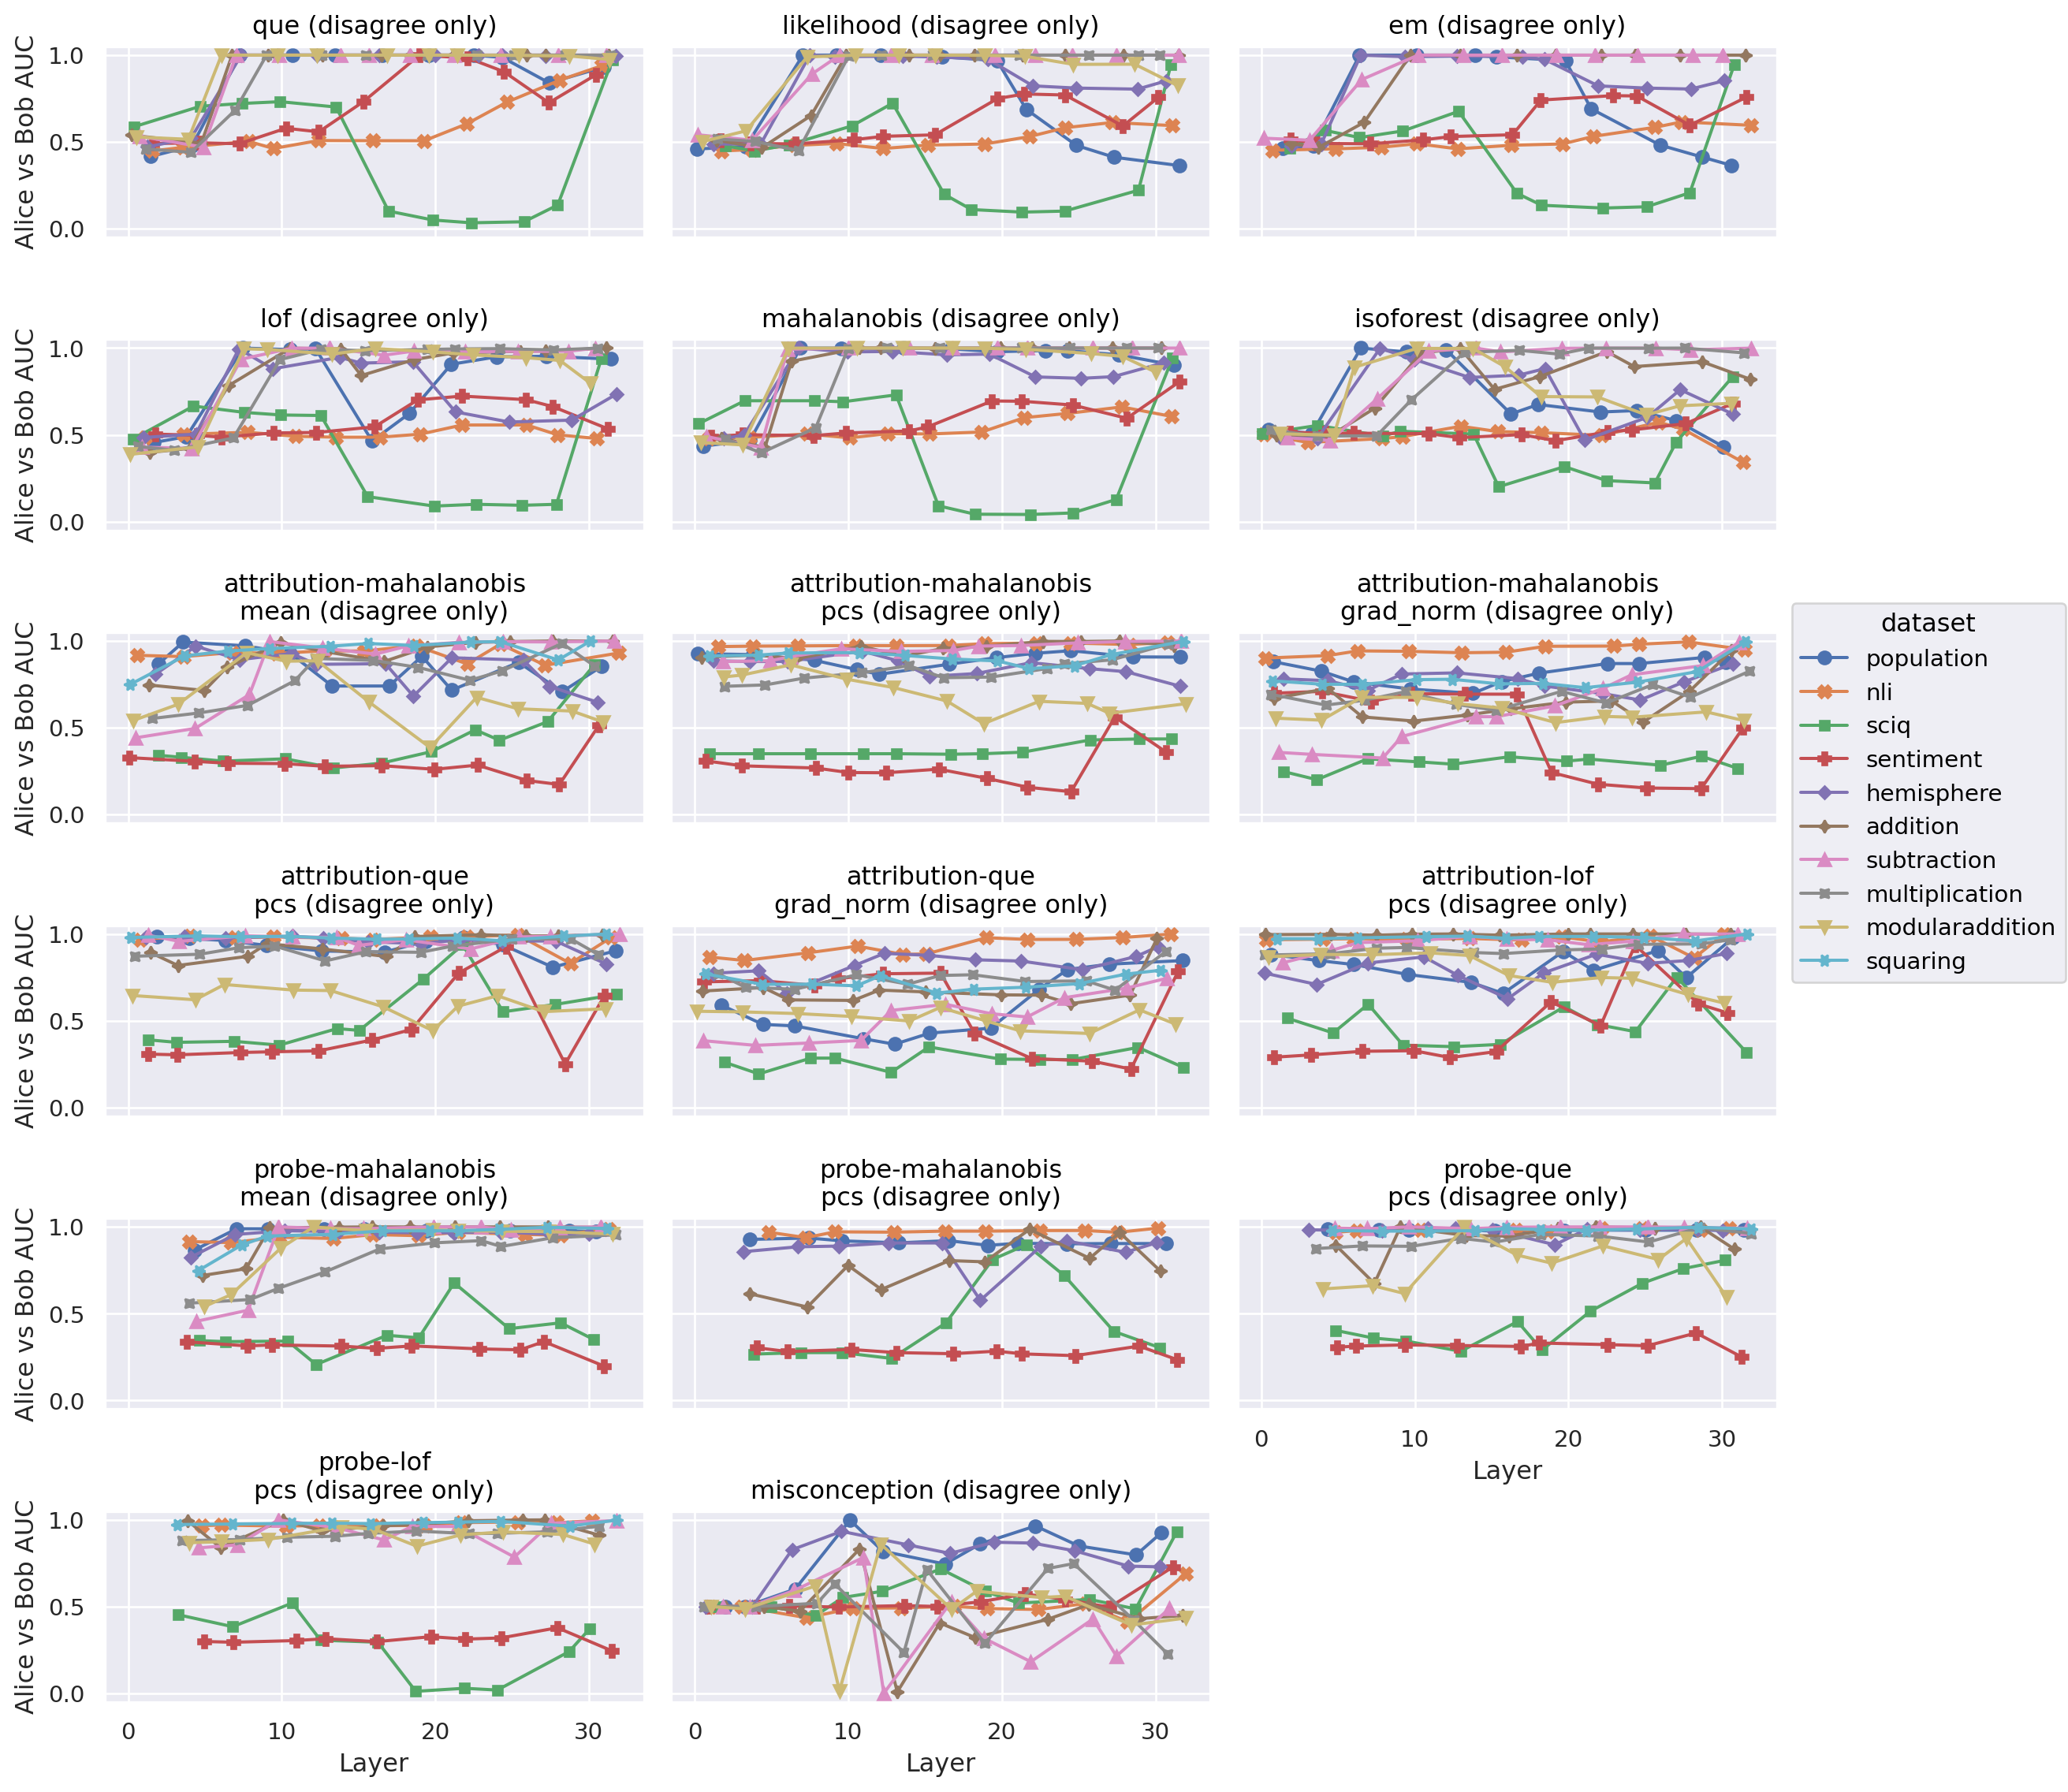

In [37]:
plot_auc_roc_by_layer_by_score(df, disagree=True)

/tmp/ipykernel_3459055/4221327954.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df, mart_df])
/tmp/ipykernel_3459055/928505572.py:220: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


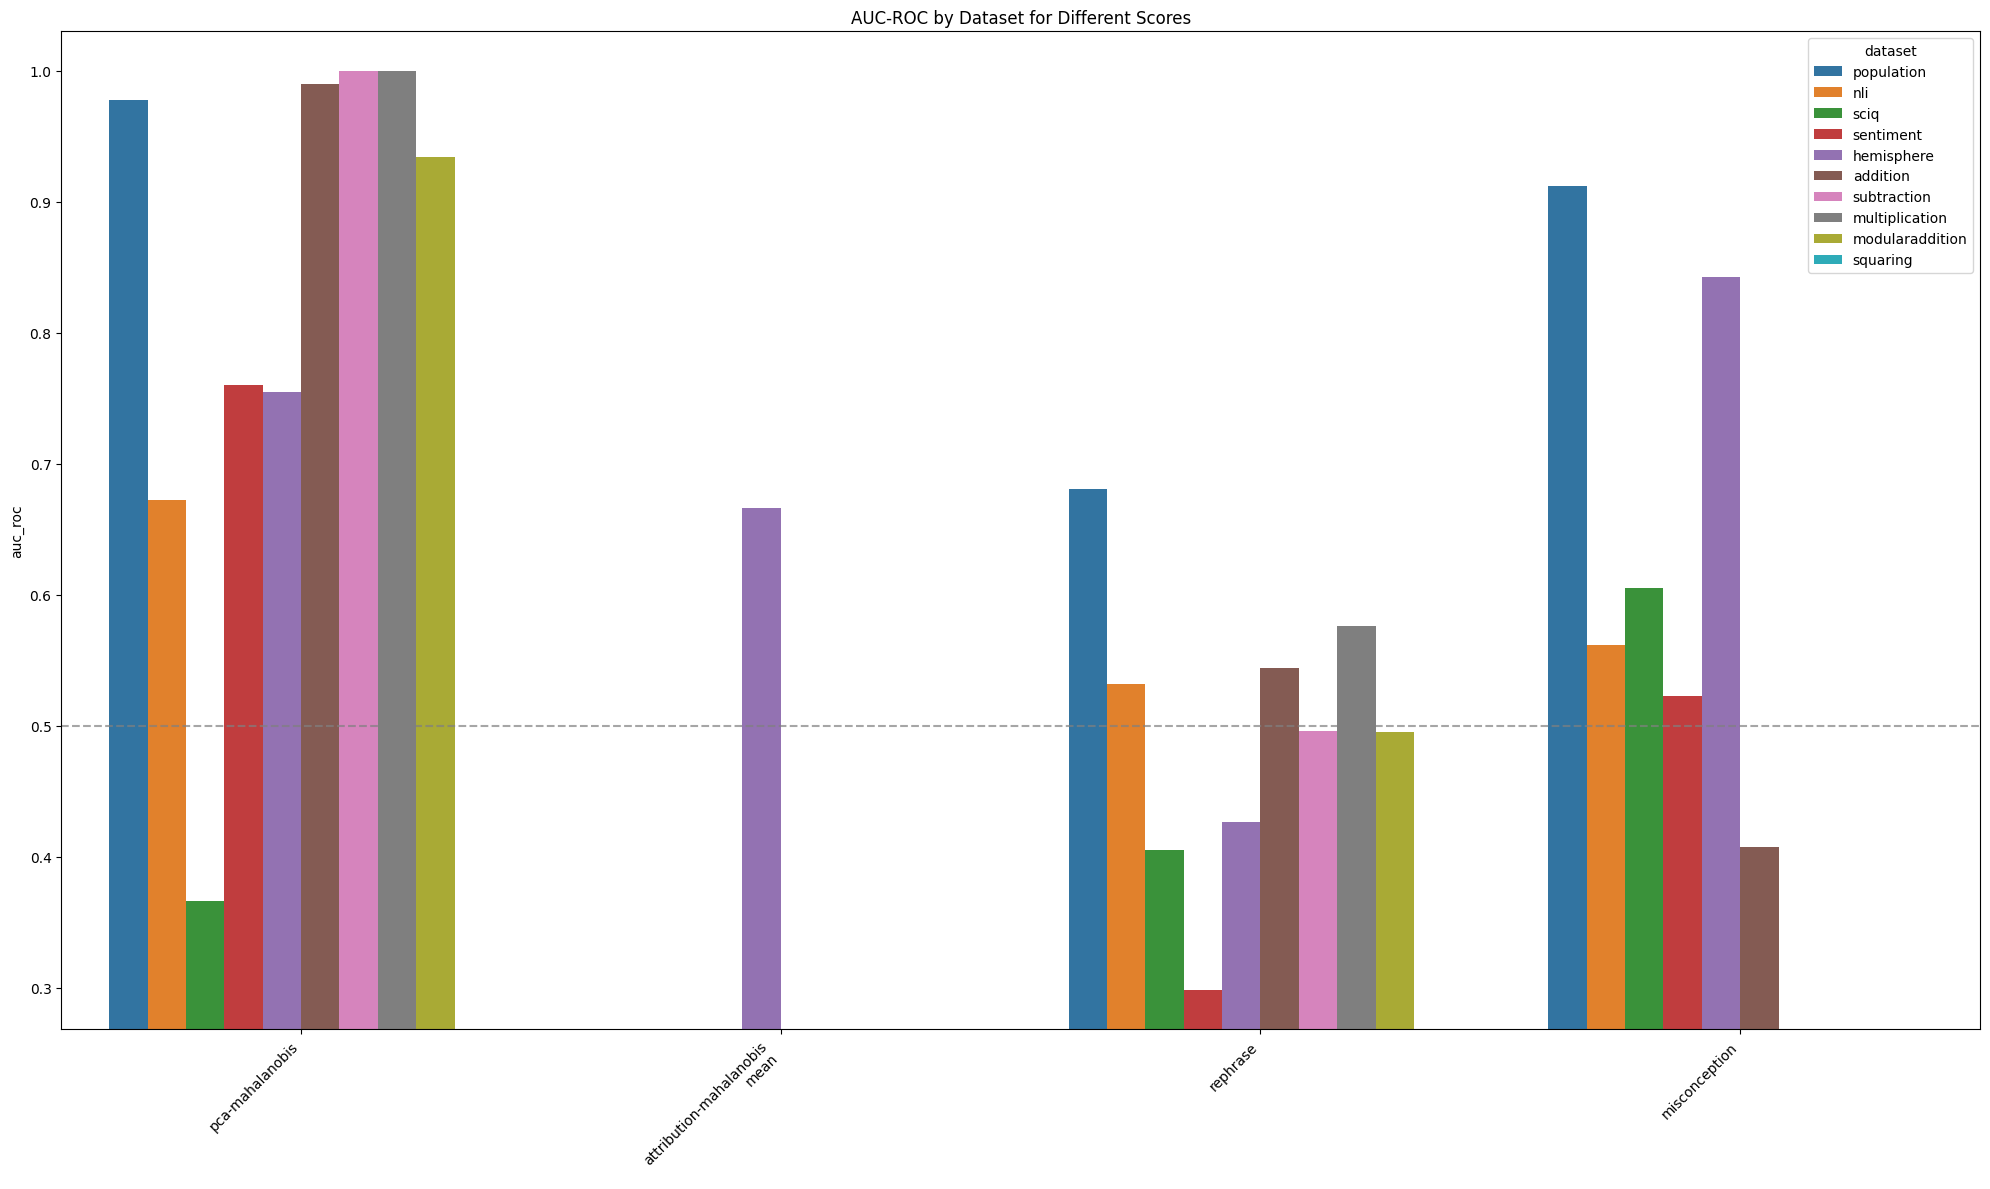

<Axes: title={'center': 'AUC-ROC by Dataset for Different Scores'}, ylabel='auc_roc'>

In [69]:
mart_df = get_data(filters['none'], log_dir=mart_logs_dir)
mart_df['score'] = 'pca-mahalanobis'
df_all = pd.concat([df, mart_df])
df_all['score'] = pd.Categorical(df_all['score'], categories=score_order, ordered=True)

plot_auc_roc_by_layer_by_score(df_all, multilayer=False)

In [67]:
df_all[df_all['score'] == 'pca-mahalanobis']

,alpha,dataset,score,features,layer,random_names,auc_roc,auc_roc_agree,auc_roc_disagree
0,None,NaN,mahalanobis,activations,-1,1,0.508442,0.510845,0.486154
1,None,multiplication,mahalanobis,activations,-1,1,1.000000,1.000000,1.000000
2,None,subtraction,mahalanobis,activations,-1,1,0.999990,0.999963,1.000000
3,None,sentiment,mahalanobis,activations,-1,1,0.760188,0.738037,0.826622
4,None,population,mahalanobis,activations,-1,1,0.977753,0.969623,0.988671
5,None,hemisphere,mahalanobis,activations,-1,1,0.754480,0.717693,0.818000
6,None,addition,mahalanobis,activations,-1,1,0.989875,0.984561,0.996389
8,None,sciq,mahalanobis,activations,-1,1,0.366565,0.495981,0.195015
9,None,modularaddition,mahalanobis,activations,-1,1,0.934417,0.920086,0.949496
10,None,nli,mahalanobis,activations,-1,1,0.672649,0.652130,0.736647


In [47]:
for dataset in df['dataset'].unique():
    print(f"\n## {dataset}\n")
    dataset_df = df[df['dataset'] == dataset].drop(columns = 'dataset')
    print(dataset_df.groupby(['score','features']).agg(np.nanmean)[['auc_roc', 'auc_roc_agree', 'auc_roc_disagree']].dropna().reset_index().to_markdown(tablefmt="github", floatfmt=".3f", index=False))


## multiplication

|    | score       | features    |   auc_roc |   auc_roc_agree |   auc_roc_disagree |
|----|-------------|-------------|-----------|-----------------|--------------------|
|  0 | que         | activations |     0.873 |           0.874 |              0.871 |
|  1 | likelihood  | activations |     0.861 |           0.861 |              0.860 |
|  2 | lof         | activations |     0.834 |           0.831 |              0.837 |
|  3 | mahalanobis | activations |     0.857 |           0.858 |              0.856 |
|  4 | isoforest   | activations |     0.821 |           0.814 |              0.829 |
|  5 | attribution-mahalanobis
pcs             | attribution |     0.767 |           0.754 |              0.828 |
|  6 | attribution-mahalanobis
grad_norm             | attribution |     0.524 |           0.485 |              0.588 |
|  7 | probe-shift
mahalanobis-mean             | probe       |     0.767 |           0.750 |              0.801 |

## modularaddition

|    | s

/tmp/ipykernel_1985408/3758915028.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(dataset_df.groupby(['score','features']).agg(np.nanmean)[['auc_roc', 'auc_roc_agree', 'auc_roc_disagree']].dropna().reset_index().to_markdown(tablefmt="github", floatfmt=".3f"))
/tmp/ipykernel_1985408/3758915028.py:4: FutureWarning: The provided callable <function nanmean at 0x734101097a30> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  print(dataset_df.groupby(['score','features']).agg(np.nanmean)[['auc_roc', 'auc_roc_agree', 'auc_roc_disagree']].dropna().reset_index().to_markdown(tablefmt="github", floatfmt=".3f"))
/tmp/ipykernel_1985408/3758915028.py:4: FutureWarning: The defa

KeyError: 'score'

NameError: name 'mart_df' is not defined

In [82]:
df_all

,alpha,dataset,score,features,layer,random_names,auc_roc,auc_roc_agree,auc_roc_disagree
0,NaN,multiplication,attribution-mahalanobis\npcs,attribution,1.0,1,0.692038,0.679923,0.738993
1,NaN,multiplication,attribution-mahalanobis\npcs,attribution,4.0,1,0.703886,0.697419,0.747009
2,NaN,multiplication,attribution-mahalanobis\npcs,attribution,7.0,1,0.731364,0.716327,0.786312
3,NaN,multiplication,attribution-mahalanobis\npcs,attribution,10.0,1,0.778837,0.775174,0.816549
4,NaN,multiplication,attribution-mahalanobis\npcs,attribution,13.0,1,0.821106,0.816938,0.857743
...,...,...,...,...,...,...,...,...,...
5,NaN,hemisphere,pca-mahalanobis,activations,21.0,1,0.754480,0.717693,0.818000
6,NaN,addition,pca-mahalanobis,activations,21.0,1,0.989875,0.984561,0.996389
8,NaN,sciq,pca-mahalanobis,activations,21.0,1,0.366565,0.495981,0.195015
9,NaN,modularaddition,pca-mahalanobis,activations,21.0,1,0.934417,0.920086,0.949496


In [86]:
%pdb on
# First, calculate the best layer for each score and feature selection method
best_layers = df_all.groupby(['score', 'features', 'layer'])['auc_roc'].mean().groupby(level=[0,1]).idxmax().dropna().apply(lambda x: x[2])

# Function to get scores for the best layer
def get_best_layer_scores(group):
    best_layer = best_layers.loc[group.name[1], group.name[2]]
    return group[group['layer'] == best_layer].iloc[0][['auc_roc', 'auc_roc_agree', 'auc_roc_disagree']]

# Calculate scores for the best layers
best_layer_scores = df_all.groupby(['dataset', 'score', 'features']).apply(lambda x: get_best_layer_scores(x)).reset_index(level=0)
best_layer_scores.columns = ['dataset', 'best_auc_roc', 'best_auc_roc_agree', 'best_auc_roc_disagree']


for dataset in df['dataset'].unique():
    print(f"\n## {dataset}\n")
    dataset_df = df_all[df_all['dataset'] == dataset].drop(columns='dataset')
    
    # Calculate mean scores for this dataset
    mean_scores = dataset_df.groupby(['score', 'features']).agg(np.nanmean)[['auc_roc', 'auc_roc_agree', 'auc_roc_disagree']].dropna()
    
    # Combine with best layer scores
    combined_scores = mean_scores.join(best_layer_scores.loc[best_layer_scores['dataset'] == dataset, ['best_auc_roc', 'best_auc_roc_agree', 'best_auc_roc_disagree']])
    
    combined_scores.loc['pca-mahalanobis',[ 'best_auc_roc', 'best_auc_roc_agree', 'best_auc_roc_disagree']] = np.nan
    # Prepare the table
    table = combined_scores.reset_index()
    table['best_layer'] = table.apply(lambda row: best_layers.loc[row['score'], row['features']], axis=1)
    
    # Reorder columns
    columns = ['score', 'features', 'auc_roc', 'best_auc_roc', 'auc_roc_agree', 'best_auc_roc_agree', 
               'auc_roc_disagree', 'best_auc_roc_disagree', 'best_layer']
    
    # Function to bold the maximum value in a column
    def bold_max(s):
        is_max = s == s.max()
        return ['**' + f'{v:.3f}' + '**' if is_max.iloc[i] else f'{v:.3f}' for i, v in enumerate(s)]
    
    # Apply bold formatting to numeric columns
    for col in columns[2:-1]:  # Exclude 'score', 'features', and 'best_layer'
        table[col] = bold_max(table[col])
    
    # Convert to markdown
    markdown_table = table[columns].to_markdown(tablefmt="github", index=False)
    
    print(markdown_table)

Automatic pdb calling has been turned ON

## multiplication

| score           | features    | auc_roc   | best_auc_roc   | auc_roc_agree   | best_auc_roc_agree   | auc_roc_disagree   | best_auc_roc_disagree   |   best_layer |
|-----------------|-------------|-----------|----------------|-----------------|----------------------|--------------------|-------------------------|--------------|
| attribution-mahalanobis
grad_norm                 | attribution | 0.524     | 0.761          | 0.485           | 0.741                | 0.588              | 0.833                   |           31 |
| attribution-mahalanobis
pcs                 | attribution | 0.767     | 0.831          | 0.754           | 0.820                | 0.828              | 0.892                   |           28 |
| isoforest       | activations | 0.821     | 0.976          | 0.814           | 0.977                | 0.829              | 0.976                   |           13 |
| likelihood      | activations | 0.861     | *

/tmp/ipykernel_1985408/2380907966.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_layer_scores = df_all.groupby(['dataset', 'score', 'features']).apply(lambda x: get_best_layer_scores(x)).reset_index(level=0)
/tmp/ipykernel_1985408/2380907966.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_layer_scores = df_all.groupby(['dataset', 'score', 'features']).apply(lambda x: get_best_layer_scores(x)).reset_index(level=0)
/tmp/ipykernel_1985408/2380907966.py:20: FutureWarning: The provided callab

In [67]:
best_layer_scores.loc[best_layer_scores['dataset'] == dataset, ['best_auc_roc', 'best_auc_roc_agree', 'best_auc_roc_disagree']]

,best_auc_roc,best_auc_roc_agree,best_auc_roc_disagree
280,1.000000,1.000000,1.000000
281,NaN,NaN,NaN
282,NaN,NaN,NaN
283,NaN,NaN,NaN
284,1.000000,1.000000,1.000000
285,NaN,NaN,NaN
286,NaN,NaN,NaN
287,NaN,NaN,NaN
288,NaN,NaN,NaN
289,NaN,NaN,NaN
